In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import midynet
import pathlib

from itertools import product
from matplotlib.lines import Line2D
from midynet.statistics import Statistics
from midynet.utility import display

paths_to_figures = [pathlib.Path("./")]

In [2]:
display.med_colors

{'blue': '#1f77b4',
 'orange': '#f19143',
 'red': '#d73027',
 'purple': '#9A80B9',
 'green': '#33b050',
 'grey': '#525252',
 'black': '#000000',
 'white': '#ffffff'}

In [3]:
ls ../../scripts/duality/data/figure3/glauber-large-annealed/


reconinfo.pkl


In [21]:
path_to_data = pathlib.Path("../../scripts/duality/data/reconheur-erdosrenyi-glauber/")

df = next(iter(pd.read_pickle("../../scripts/duality/data/figure3/glauber-large-meanfield/reconinfo.pkl").values()))
mf = Statistics.from_dataframe(df, "mutualinfo")
mf.rescale_(1/8)
mf_x = df["data_model.coupling"]

df = next(iter(pd.read_pickle("../../scripts/duality/data/figure3/glauber-large-annealed/reconinfo.pkl").values()))
ais = Statistics.from_dataframe(df, "mutualinfo")
# ais.rescale_(1/8)
ais_x = df["data_model.coupling"]

prior = df["prior-loc"][0]

df = next(iter(pd.read_pickle(path_to_data / "reconheuristics.pkl").values()))
methods = df["metrics.method"].values
h_x = df["data_model.coupling"]
all_methods = np.unique(methods)
heuristics = Statistics.from_dataframe(df, "auc")
# heuristics.rescale_(1/8)

method_labels = {
    "correlation": "Correlation",
    "granger_causality": "Granger",
    "transfer_entropy": "TE",
}


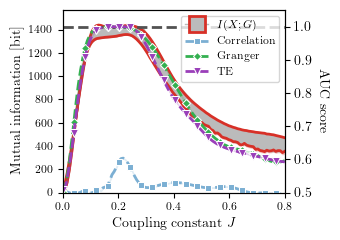

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))

rcolor = display.med_colors["red"]
rmarker = "o"
rlinestyle = "-"

hcolor = [display.light_colors["blue"], display.med_colors["green"], display.dark_colors["purple"]]
hmarker = ["s", "D", "v"]
hlinestyle = ["--"] * 3

fcolor = "#bbbbbb"

mf.clip(min=0, max=prior).lineplot(
    mf_x, 
    color=rcolor, 
    marker="None", 
    linestyle=rlinestyle, 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
)

ais.clip(min=0, max=prior).lineplot(
    ais_x, 
    color=rcolor, 
    marker="None", 
    linestyle=rlinestyle, 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
)

augx, mf_augy = mf.interpolate(mf_x, kind="cubic")
_, ais_augy = ais.interpolate(ais_x, kind="cubic")
mf_augy = mf_augy.clip(0, prior)
ais_augy = ais_augy.clip(0, prior)
ax.fill_between(augx, mf_augy.loc, ais_augy.loc, color=fcolor)
handles = [
    display.get_label_line(
        r"$I(X;G)$", 
        marker="s",
        markersize=12,
        color=fcolor,
        markeredgecolor=display.med_colors["red"],
        alpha=1,
        markeredgewidth=2,
    )
]

ax.axhline(prior, color=display.med_colors["grey"], linewidth=2, linestyle="--")
ax.set_xlabel(r"Coupling constant $J$", fontsize=display.fontsizes["label"])
ax.set_ylabel(r"Mutual information [bit]", fontsize=display.fontsizes["label"])
ax.set_xlim([mf_x.min(), mf_x.max()])
ax.set_ylim([0, prior * 1.1])
ax.tick_params(axis="both", labelsize=display.fontsizes["tick"])

axx = ax.twinx()
# ax.set_zorder(axx.get_zorder() + 1)
# ax.patch.set_visible(False)
for i, m in enumerate(all_methods):
    idx = methods == m
    x = h_x[idx]
    heuristics[idx].lineplot(
        x, 
        color=hcolor[i],
        linestyle=hlinestyle[i],
        marker=hmarker[i],
        linewidth=2,
        markersize=6 if i == 2 else 4,
        interpolate="cubic",
        markevery=5,
        n_boot=1000,
    )
    handles.append(display.get_label_line(method_labels[m], style=axx.get_lines()[-1]))
axx.set_ylim([0.5, 1.05])
axx.set_ylabel(r"AUC score", rotation=-90, ha="center", va="bottom", fontsize=display.fontsizes["label"])
ax.legend(handles=handles, fontsize=display.fontsizes["legend"], loc="upper right")

fig.tight_layout()

for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
    fig.savefig(p / f"{fmt}/mi-vs-heuristics.{fmt}", bbox_inches='tight')
